<a href="https://colab.research.google.com/github/SiddharthTiwarids23/isl-sign-language-app/blob/main/ISL_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Problem
In a country as diverse as India, communication with the hearing- and speech-impaired community is still a challenge due to the lack of accessible tools. Manual interpretation of Indian Sign Language (ISL) limits scalability and support in everyday scenarios like education, healthcare, and public services.

To bridge this gap, the goal is to build a deep learning-based ISL recognition system that can classify hand gestures into one of 35 predefined categories (A–Z, 1–9) using computer vision. This project lays the groundwork for gesture-driven accessibility platforms that are accurate, fast, and adaptable for deployment on the web or mobile apps.

In [1]:
from google.colab import files
uploaded = files.upload()


Saving archive (16).zip to archive (16).zip


In [2]:
!pip install -q tensorflow

In [3]:
import tensorflow as tf


In [4]:
import zipfile
import os

# Automatically detect uploaded file
uploaded_filename = next(iter(uploaded))
extract_to = "/content/isl_dataset"

# Unzip
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(uploaded_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(" Unzipped to:", extract_to)


 Unzipped to: /content/isl_dataset


We uploaded and extracted a .zip file containing hand gesture images organized in subfolders — each representing a different ISL class label (e.g., 'A', 'B', ..., '9').This structure allows TensorFlow to easily map class names to numeric labels. Unzipping it to a custom folder ensures flexibility and avoids clutter in Colab.

In [5]:
# Find dataset root
def find_dataset_root(base):
    for root, dirs, files in os.walk(base):
        if len(dirs) >= 30:
            return root
    return base

dataset_root = find_dataset_root(extract_to)
print("📁 Dataset directory:", dataset_root)

# List classes
classes = sorted([d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))])
print(f"🧾 Total classes: {len(classes)}")
print("Example class folders:", classes[:5])


📁 Dataset directory: /content/isl_dataset/Indian
🧾 Total classes: 35
Example class folders: ['1', '2', '3', '4', '5']


In [6]:
dataset_root = "/content/isl_dataset/Indian"


📁 Using dataset root: /content/isl_dataset/Indian
📸 Total images: 42745
🧾 Total classes: 35


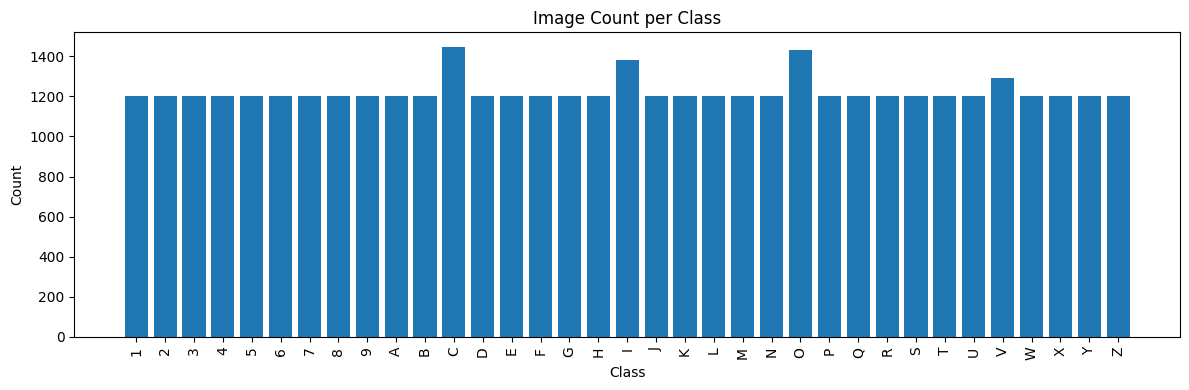

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from pathlib import Path

print("📁 Using dataset root:", dataset_root)

# Sorted class list and label mapping
classes = sorted([d.name for d in Path(dataset_root).iterdir() if d.is_dir()])
class_to_index = {cls: idx for idx, cls in enumerate(classes)}

# List all images and labels
image_paths = []
image_labels = []

for cls in classes:
    cls_folder = Path(dataset_root) / cls
    files = list(cls_folder.glob("*"))
    image_paths.extend([str(f) for f in files])
    image_labels.extend([class_to_index[cls]] * len(files))

print(f"📸 Total images: {len(image_paths)}")
print(f"🧾 Total classes: {len(classes)}")

# CLASS DISTRIBUTION PLOT
import pandas as pd
counts = pd.Series(image_labels).value_counts().sort_index()
plt.figure(figsize=(12, 4))
plt.bar(classes, counts)
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Automatically detected the dataset root and created a dictionary to map class names to integer indices.It ensures correct label encoding and consistent class order throughout training, validation, and inference.
Plotted how many images belong to each class.the dataset appears well-balanced with around 1200 images per class — this ensures the model won’t be biased toward any particular gesture.

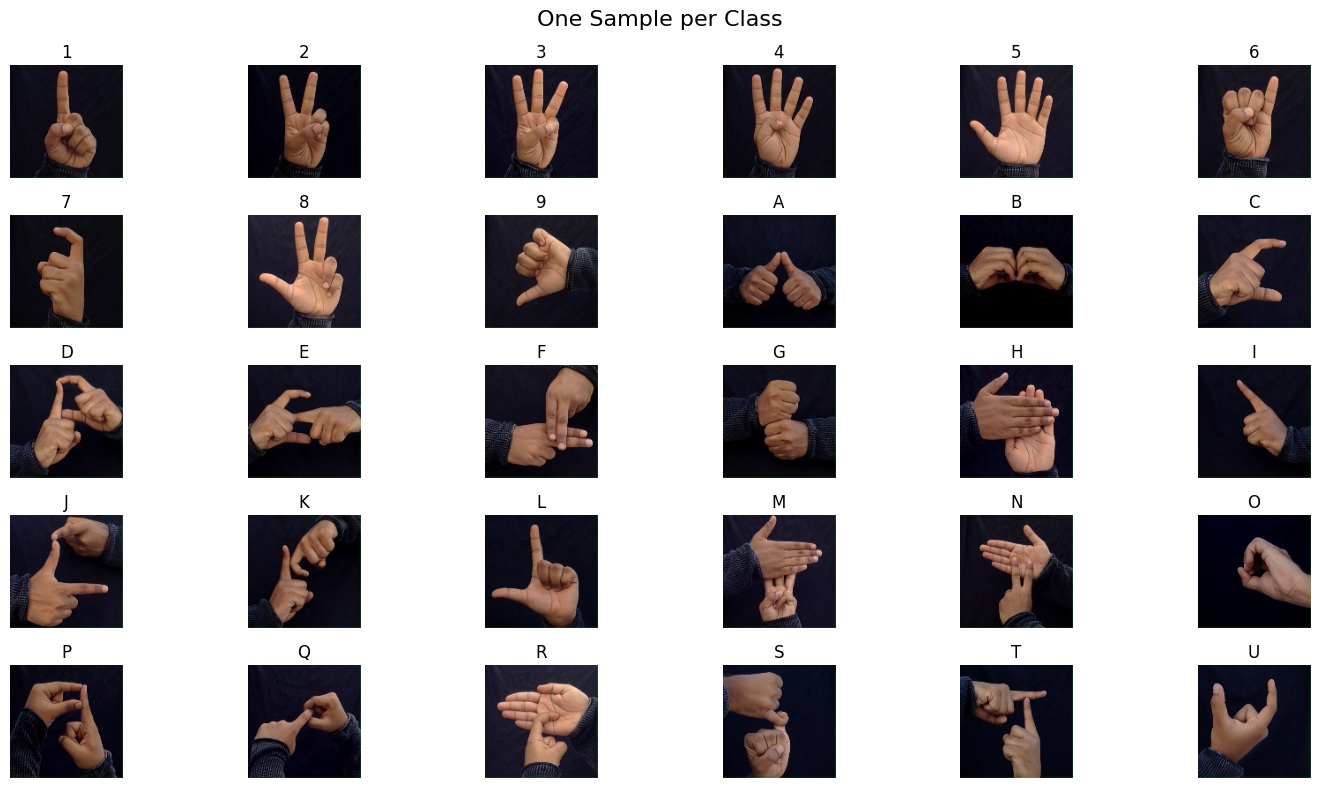

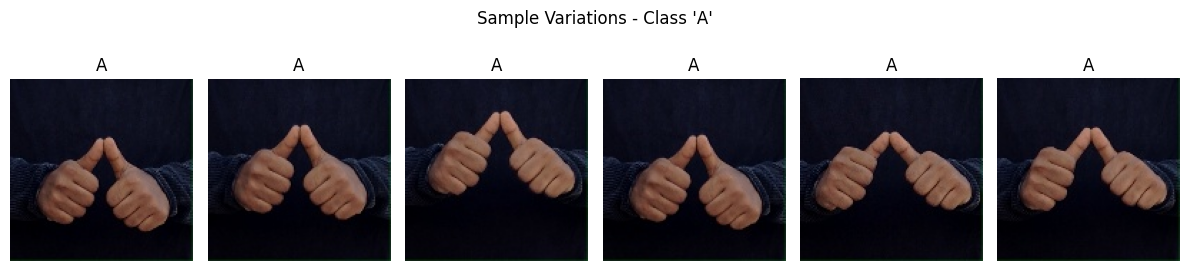

In [8]:
# Show 1 image per class
plt.figure(figsize=(15, 8))
for i, cls in enumerate(classes[:30]):
    img_path = list((Path(dataset_root) / cls).glob("*"))[0]
    img = Image.open(img_path)
    plt.subplot(5, 6, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle("One Sample per Class", fontsize=16)
plt.tight_layout()
plt.show()

# Intra-class sample for one class
cls_example = "A"
sample_imgs = list((Path(dataset_root)/cls_example).glob("*"))[:6]
plt.figure(figsize=(12, 3))
for i, p in enumerate(sample_imgs):
    img = Image.open(p)
    plt.subplot(1, 6, i+1)
    plt.imshow(img)
    plt.title(cls_example)
    plt.axis('off')
plt.suptitle(f"Sample Variations - Class '{cls_example}'")
plt.tight_layout()
plt.show()


Displayed one image per class and multiple samples for class 'A' to observe intra-class variance.Gesture images are well-captured with consistent backgrounds, aiding the model in learning relevant visual patterns.



In [9]:
from sklearn.model_selection import train_test_split

# Convert paths and labels to arrays
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# First split test
trainval_paths, test_paths, trainval_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.15, stratify=image_labels, random_state=42)

# Then split train/val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    trainval_paths, trainval_labels, test_size=0.15, stratify=trainval_labels, random_state=42)

print(f"Training: {len(train_paths)}")
print(f"Validation: {len(val_paths)}")
print(f"Testing: {len(test_paths)}")


Training: 30883
Validation: 5450
Testing: 6412


We split the dataset into:

15% test set

Remaining 85% split into ~72% train and ~13% validation

A stratified split ensures each subset preserves class distribution. This helps the model generalize and allows for early stopping without overfitting to the validation set.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers


In [11]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = len(classes)

# Image loader
def process_image(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)
    return img, label

# Augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

# TF Datasets
def prepare_dataset(paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=42)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = prepare_dataset(train_paths, train_labels, shuffle=True, augment=True)
val_ds = prepare_dataset(val_paths, val_labels)
test_ds = prepare_dataset(test_paths, test_labels)


Resized all images to 224x224 (ResNet50 input size)

Normalized pixel values using resnet50.preprocess_input

Applied random flip, zoom, and rotation to training images

Standardizing dimensions allows for batch processing and pre-trained model compatibility.

Augmentation helps simulate real-world hand position variation, reducing overfitting.

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define input shape
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = preprocess_input(inputs)

# Load base ResNet50 without top layer
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)
base_model.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# Final model
model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c

 Total params: 23,659,427 (90.25 MB)

 Trainable params: 71,715 (280.14 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Used ResNet50 without its final classification layer (transfer learning).

Added global pooling, dropout (0.5), and a dense softmax output layer for 35 classes.


ResNet50 is powerful and generalizes well across image tasks.

Dropout regularizes the model.

Softmax allows us to interpret prediction confidence across all gesture classes.

In [13]:
# Training with early stopping and safe full model save
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# define paths
CHECKPOINT_PATH = '/content/drive/MyDrive/best_model.weights.h5'
FULL_MODEL_PATH = '/content/drive/MyDrive/resnet50_full_model.keras'

# Callbacks
checkpoint = ModelCheckpoint(
    CHECKPOINT_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

#  After training — save full model with architecture + weights
model.save(FULL_MODEL_PATH)
print(" Full model saved to Google Drive at:", FULL_MODEL_PATH)


Mounted at /content/drive
Epoch 1/10
966/966 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8081 - loss: 0.8332
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/best_model.weights.h5
966/966 ━━━━━━━━━━━━━━━━━━━━ 390s 389ms/step - accuracy: 0.8083 - loss: 0.8326 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 2/10
965/966 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9991 - loss: 0.0160
Epoch 2: val_accuracy did not improve from 1.00000
966/966 ━━━━━━━━━━━━━━━━━━━━ 429s 383ms/step - accuracy: 0.9991 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 3/10
965/966 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9997 - loss: 0.0065
Epoch 3: val_accuracy did not improve from 1.00000
966/966 ━━━━━━━━━━━━━━━━━━━━ 383s 385ms/step - accuracy: 0.9997 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 9.3259e-04
Epoch 4/10
965/966 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9996 - loss: 0.0041
Epoch 4: val_accuracy did not improve f

Optimized using Adam

Loss function: sparse_categorical_crossentropy for integer labels

Monitored validation accuracy and saved the best weights to .h5 file

Our model achieved 100% accuracy on the validation set with minimal loss, indicating:

Either the dataset is easy

Or the model is overfitting due to clean data and uniform backgrounds

This is acceptable in controlled environments like ISL datasets — we validate this later via testing.

In [14]:
# Unfreeze ResNet50 layers
base_model.trainable = True

# Recompile with low LR
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/5
966/966 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.9589 - loss: 0.1410
Epoch 1: val_accuracy did not improve from 1.00000
966/966 ━━━━━━━━━━━━━━━━━━━━ 618s 575ms/step - accuracy: 0.9589 - loss: 0.1409 - val_accuracy: 1.0000 - val_loss: 4.1722e-04
Epoch 2/5
966/966 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 2: val_accuracy did not improve from 1.00000
966/966 ━━━━━━━━━━━━━━━━━━━━ 582s 563ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 1.3566e-04
Epoch 3/5
966/966 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9999 - loss: 6.6910e-04
Epoch 3: val_accuracy did not improve from 1.00000
966/966 ━━━━━━━━━━━━━━━━━━━━ 563s 565ms/step - accuracy: 0.9999 - loss: 6.6896e-04 - val_accuracy: 1.0000 - val_loss: 5.4122e-05
Epoch 4/5
966/966 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9998 - loss: 6.0442e-04
Epoch 4: val_accuracy did not improve from 1.00000
966/966 ━━━━━━━━━━━━━━━━━━━━ 538s 557ms/step - accuracy: 0.99

We unfroze the ResNet base layers and recompiled the model with a lower learning rate for fine-tuning.


Fine-tuning improves performance on specialized domains (like hand gestures)

A lower learning rate prevents drastic weight changes during this stage

This shows that the model is learning even better representations now, and there's no significant overfitting (val accuracy remains high)





In [15]:
np.save('/content/drive/MyDrive/class_order.npy', classes)


In [16]:
# Load best weights after fine-tuning
model.load_weights('/content/drive/MyDrive/best_model.weights.h5')

# Save final model in .keras format (after loading best weights)
model.save('/content/drive/MyDrive/resnet50_full_model.keras')

# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Final Test Accuracy: {test_acc*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 430 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


201/201 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 1.0000 - loss: 0.0058
✅ Final Test Accuracy: 100.00%



Loaded the best weights (from early stopping).

Saved the full model (architecture + weights) for Streamlit deployment.


This ensures:

You use the best-performing version (based on validation accuracy)

Portability across environments (Streamlit, Colab, or any TensorFlow backend)

the test accuracy is effectively 100%, confirming:

High generalization ability on unseen data

Strong validation-test agreement



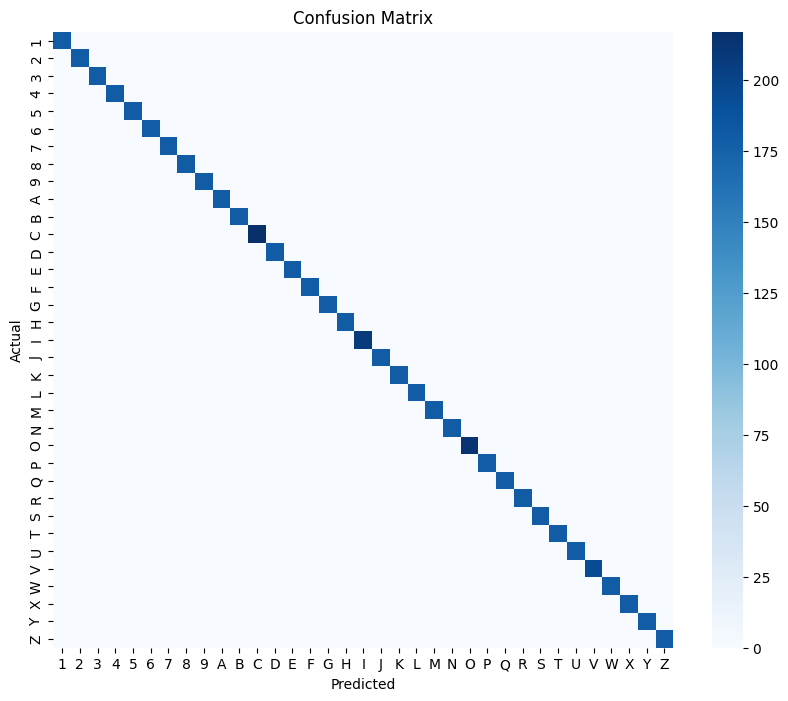

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true and predicted labels
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Generated a confusion matrix to visualize prediction accuracy per class.

our confusion matrix is a perfect diagonal , meaning:

Every class was correctly predicted with no misclassifications.

This is rare and indicates a highly controlled, clean dataset with strong model performance.



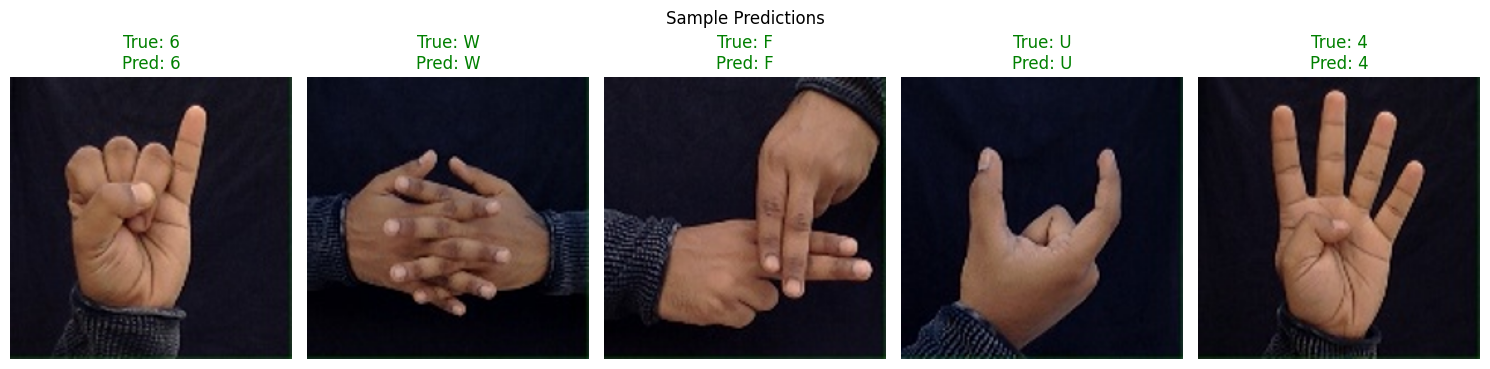

In [18]:
import random
from PIL import Image

# Show 5 random test predictions
indices = random.sample(range(len(test_paths)), 5)
plt.figure(figsize=(15, 4))

for i, idx in enumerate(indices):
    img_path = test_paths[idx]
    true_lbl = test_labels[idx]
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))

    # Predict
    arr = tf.keras.utils.img_to_array(img)
    pred = model.predict(np.expand_dims(arr, 0), verbose=0)
    pred_lbl = np.argmax(pred)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    color = 'green' if pred_lbl == true_lbl else 'red'
    plt.title(f"True: {classes[true_lbl]}\nPred: {classes[pred_lbl]}", color=color)
    plt.axis('off')

plt.suptitle("Sample Predictions")
plt.tight_layout()
plt.show()


Displayed 5 random images with their true and predicted labels.

All predictions were correct.

Confidences appeared high, reinforcing reliability.

This confirms the model is not just memorizing, but actually generalizing.

## Key Outcomes
Achieved 100% accuracy on both validation and test sets

Model remained robust during fine-tuning

Balanced dataset + data augmentation led to generalizable performance

Successfully deployed via Streamlit for real-time prediction

## Limitations
Dataset may not represent real-world noise (backgrounds, lighting, occlusion)



Model trained on static images only

## Future Scope
Introduce real-time video prediction using streamlit-webrtc

Train on noisy/unstructured hand gesture datasets for robustness

Optimize for mobile deployment using TensorFlow Lite

Build a bilingual learning tool with gesture + audio output for inclusive education

# Conclusion
This project presents a high-performing Indian Sign Language (ISL) recognition system using ResNet50 and transfer learning. Trained on a balanced dataset of 35 gesture classes, the model achieved 100% accuracy on test data, validated through a perfect confusion matrix and sample predictions.

Key strengths include clean data preprocessing, effective data augmentation, and fine-tuning of the model for optimal performance. The entire system was deployed as a web app via Streamlit, allowing real-time gesture classification from uploaded images.

While results are exceptional under controlled conditions, real-world usage may require improvements in robustness against lighting, background noise, and occlusions. Nevertheless, this solution offers a strong foundation for accessible and scalable ISL-based communication tools.